In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [18]:
df_enc = pd.read_csv("data/enc/data-enc-2024-05-06.csv")

In [19]:
df_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132786 entries, 0 to 132785
Data columns (total 86 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   avg_price_5                       132786 non-null  float64
 1   bathrooms_total                   132786 non-null  float64
 2   bedrooms_extra                    132786 non-null  float64
 3   bedrooms                          132786 non-null  float64
 4   stories_total                     132786 non-null  float64
 5   size_interior                     132786 non-null  float64
 6   lng                               132786 non-null  float64
 7   lat                               132786 non-null  float64
 8   parkings                          132786 non-null  float64
 9   price                             132786 non-null  float64
 10  household_income                  132786 non-null  float64
 11  individual_income                 132786 non-null  f

In [20]:
df_ON = df_enc[df_enc["province_Ontario"] == True]
df_QC = df_enc[df_enc["province_Quebec"] == True]
df_BC = df_enc[df_enc["province_British Columbia"] == True]
df_AB = df_enc[df_enc["province_Alberta"] == True]
df_SK = df_enc[df_enc["province_Saskatchewan"] == True]
df_MB = df_enc[df_enc["province_Manitoba"] == True]
# East
df_ES = df_enc[(df_enc["province_Nova Scotia"] == True) |
               (df_enc["province_New Brunswick"] == True) |
               (df_enc["province_Newfoundland & Labrador"] == True) |
               (df_enc["province_Prince Edward Island"] == True)]
# North
df_NO = df_enc[(df_enc["province_Yukon"] == True) |
               (df_enc["province_Northwest Territories"] == True)]

df_ON = df_ON.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta", "province_Saskatchewan",
                    "province_Manitoba", "province_Nova Scotia", "province_New Brunswick", "province_Newfoundland & Labrador",
                    "province_Prince Edward Island", "province_Yukon", "province_Northwest Territories"], axis=1)
df_QC = df_QC.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta", "province_Saskatchewan",
                    "province_Manitoba", "province_Nova Scotia", "province_New Brunswick", "province_Newfoundland & Labrador",
                    "province_Prince Edward Island", "province_Yukon", "province_Northwest Territories"], axis=1)
df_BC = df_BC.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta", "province_Saskatchewan",
                    "province_Manitoba", "province_Nova Scotia", "province_New Brunswick", "province_Newfoundland & Labrador",
                    "province_Prince Edward Island", "province_Yukon", "province_Northwest Territories"], axis=1)
df_AB = df_AB.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta", "province_Saskatchewan",
                    "province_Manitoba", "province_Nova Scotia", "province_New Brunswick", "province_Newfoundland & Labrador",
                    "province_Prince Edward Island", "province_Yukon", "province_Northwest Territories"], axis=1)
df_SK = df_SK.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta", "province_Saskatchewan",
                    "province_Manitoba", "province_Nova Scotia", "province_New Brunswick", "province_Newfoundland & Labrador",
                    "province_Prince Edward Island", "province_Yukon", "province_Northwest Territories"], axis=1)
df_MB = df_MB.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta", "province_Saskatchewan",
                    "province_Manitoba", "province_Nova Scotia", "province_New Brunswick", "province_Newfoundland & Labrador",
                    "province_Prince Edward Island", "province_Yukon", "province_Northwest Territories"], axis=1)
df_ES = df_ES.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta",
                    "province_Saskatchewan","province_Manitoba", "province_Yukon", "province_Northwest Territories"], axis=1)
df_NO = df_NO.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta",
                    "province_Saskatchewan", "province_Manitoba", "province_Nova Scotia", "province_New Brunswick",
                    "province_Newfoundland & Labrador", "province_Prince Edward Island"], axis=1)

In [21]:
df_ON.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62579 entries, 0 to 129909
Data columns (total 74 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   avg_price_5                    62579 non-null  float64
 1   bathrooms_total                62579 non-null  float64
 2   bedrooms_extra                 62579 non-null  float64
 3   bedrooms                       62579 non-null  float64
 4   stories_total                  62579 non-null  float64
 5   size_interior                  62579 non-null  float64
 6   lng                            62579 non-null  float64
 7   lat                            62579 non-null  float64
 8   parkings                       62579 non-null  float64
 9   price                          62579 non-null  float64
 10  household_income               62579 non-null  float64
 11  individual_income              62579 non-null  float64
 12  commute_transit                62579 non-null  flo

In [22]:
df_BC.corr(numeric_only=True)["price"].sort_values(ascending=False).head(20)

price                         1.000000
avg_price_5                   0.709932
size_interior                 0.575532
bedrooms                      0.474122
bathrooms_total               0.473291
individual_income             0.464780
household_income              0.464780
building_type_House           0.394412
ownership_type_group_ids_1    0.380635
parkings                      0.323869
age_15_to_19                  0.248829
area_duplex                   0.246818
edu_post_graduate_degree      0.237477
edu_bachelor_degree           0.233272
multi_family                  0.232772
single_family                 0.230189
edu_university_certificate    0.189329
lang_other                    0.177625
loc_parks                     0.164603
age_10_to_14                  0.164188
Name: price, dtype: float64

## Raw Input

In [23]:
kf = KFold(n_splits=10)

In [24]:
cb1 = CatBoostRegressor(silent=True)

X = df_ON.drop("price", axis=1)
y = df_ON["price"]

scores1 = cross_val_score(cb1, X, y, cv=kf, scoring="r2")

print(f"\n{scores1}\n")
pd.Series(scores1).describe()


[0.66090031 0.75810047 0.52571343 0.68070442 0.73822469 0.73697801
 0.7492808  0.73189064 0.69531843 0.71537652]



count    10.000000
mean      0.699249
std       0.068459
min       0.525713
25%       0.684358
50%       0.723634
75%       0.737913
max       0.758100
dtype: float64

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cb1.fit(X_train, y_train)
y_pred = cb1.predict(X_test)

In [26]:
r2_score(y_test, y_pred)

0.7352920287210065

In [27]:
root_mean_squared_error(y_test, y_pred)

268868.23098291387

In [28]:
y_df1 = pd.DataFrame({"y_test":y_test.values, "y_pred":y_pred})

In [29]:
np.round(y_df1.head(20))

,y_test,y_pred
0,1250000.0,1501498.0
1,1350000.0,1451416.0
2,1399000.0,1048280.0
3,779900.0,879161.0
4,1450000.0,1488185.0
5,1729000.0,1837085.0
6,699900.0,621899.0
7,599000.0,465999.0
8,695000.0,601015.0
9,939900.0,932484.0


## Scaled

In [30]:
cb2 = CatBoostRegressor(silent=True)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.to_numpy().reshape(-1,1))

scores2 = cross_val_score(cb2, X_scaled, y_scaled, cv=kf, scoring="r2")

print(f"\n{scores2}\n")
pd.Series(scores2).describe()


[0.66144399 0.756041   0.53109181 0.67565905 0.73903217 0.73193057
 0.74959278 0.7311617  0.69726062 0.71805977]



count    10.000000
mean      0.699127
std       0.066708
min       0.531092
25%       0.681059
50%       0.724611
75%       0.737257
max       0.756041
dtype: float64

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

cb2.fit(X_train, y_train)
y_pred = cb2.predict(X_test)

In [32]:
r2_score(y_test, y_pred)

0.7332072772411902

In [33]:
root_mean_squared_error(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(y_pred.reshape(-1,1)))

269924.9126924196

In [34]:
y_df2 = pd.DataFrame({"y_test":scaler_y.inverse_transform(y_test[:,0].reshape(-1,1))[:,0].tolist(),
                      "y_pred":scaler_y.inverse_transform(y_pred.reshape(-1,1))[:,0].tolist()})

In [35]:
np.round(y_df2.head(20))

,y_test,y_pred
0,1250000.0,1514048.0
1,1350000.0,1434674.0
2,1399000.0,1037494.0
3,779900.0,928165.0
4,1450000.0,1466396.0
5,1729000.0,1824366.0
6,699900.0,641210.0
7,599000.0,466156.0
8,695000.0,603076.0
9,939900.0,966545.0


## log1p: X Only

In [36]:
from scipy import stats

sub_df = df_AB.copy(deep=True)

skew_df = pd.DataFrame(sub_df.columns, columns=["Feature"])
skew_df["Corr_Price_Before"] = sub_df.corr()["price"].values
skew_df["Skew_Before"] = skew_df["Feature"].apply(lambda feature: stats.skew(sub_df[feature]))
skew_df["AbsSkew_Before"] = skew_df["Skew_Before"].apply(abs)
skew_df["Skewed_Before"] = skew_df["AbsSkew_Before"].apply(lambda x: True if x>= 0.5 else False)

# before_log = set(skew_df.query("Skewed_Before == True")["Feature"].values)

for column in skew_df.query("Skewed_Before == True")["Feature"].values:
    if column != "price":
        sub_df[column] = np.log1p(sub_df[column])


# skew_df = pd.DataFrame(sub_df.columns, columns=["Feature"])
skew_df["Corr_Price_After"] = sub_df.corr()["price"].values
skew_df["Skew_After"] = skew_df["Feature"].apply(lambda feature: stats.skew(sub_df[feature]))
skew_df["AbsSkew_After"] = skew_df["Skew_After"].apply(abs)
skew_df["Skewed_After"] = skew_df["AbsSkew_After"].apply(lambda x: True if x>= 0.5 else False)

# after_log = set(skew_df.query("Skewed_Before == True")["Feature"].values)

# log_columns = list(before_log - after_log - {"price", "lng", "lat"})
log_columns = skew_df[(skew_df["Skewed_Before"]==True) & (skew_df["Corr_Price_After"] > skew_df["Corr_Price_Before"])]["Feature"].values

log_columns

/home/soheil/codes/House-Pred-CA/House-Pred-CA/.venv/lib64/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


array(['bedrooms_extra', 'commute_transit', 'commute_drive',
       'lang_en_only', 'lang_en_and_fr', 'edu_post_graduate_degree',
       'area_apt_5_plus_floors', 'loc_wellness', 'loc_greenery',
       'building_type_Row / Townhouse', 'ownership_type_group_ids_1',
       'ownership_type_group_ids_2'], dtype=object)

In [37]:
cb3 = CatBoostRegressor(silent=True)

X_log = X.copy(deep=True)
X_log[log_columns] = np.log1p(X_log[log_columns])

X_scaled = scaler_X.fit_transform(X_log)
y_scaled = scaler_y.fit_transform(y.to_numpy().reshape(-1,1))

scores3 = cross_val_score(cb3, X_scaled, y_scaled, cv=kf, scoring="r2")

print(f"\n{scores3}\n")
pd.Series(scores3).describe()


[0.66144399 0.756041   0.53109181 0.67565618 0.73903217 0.73193057
 0.74959158 0.7311617  0.69726062 0.7180603 ]



count    10.000000
mean      0.699127
std       0.066708
min       0.531092
25%       0.681057
50%       0.724611
75%       0.737257
max       0.756041
dtype: float64

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

cb3.fit(X_train, y_train)
y_pred = cb3.predict(X_test)

In [39]:
r2_score(y_test, y_pred)

0.7332071999443219

In [40]:
root_mean_squared_error(y_test, y_pred)

0.5117981102193983

In [41]:
y_df3 = pd.DataFrame({"y_test":scaler_y.inverse_transform(y_test[:,0].reshape(-1,1))[:,0].tolist(),
                      "y_pred":scaler_y.inverse_transform(y_pred.reshape(-1,1))[:,0].tolist()})

In [42]:
np.round(y_df3.head(20))

,y_test,y_pred
0,1250000.0,1514048.0
1,1350000.0,1434674.0
2,1399000.0,1037494.0
3,779900.0,928165.0
4,1450000.0,1466396.0
5,1729000.0,1824366.0
6,699900.0,641210.0
7,599000.0,466156.0
8,695000.0,603076.0
9,939900.0,966545.0


# log1p: X and y

In [43]:
cb4 = CatBoostRegressor(silent=True)

X_log = X.copy(deep=True)
X_log[log_columns] = np.log1p(X_log[log_columns])

y_log = np.log1p(y)

X_scaled = scaler_X.fit_transform(X_log)
y_scaled = scaler_y.fit_transform(y_log.to_numpy().reshape(-1,1))

scores4 = cross_val_score(cb4, X_scaled, y_scaled, cv=kf, scoring="r2")

print(f"\n{scores4}\n")
pd.Series(scores4).describe()


[0.78956845 0.86018463 0.70928483 0.76748261 0.8303044  0.8290646
 0.82535418 0.82366756 0.80935039 0.81990591]



count    10.000000
mean      0.806417
std       0.042237
min       0.709285
25%       0.794514
50%       0.821787
75%       0.828137
max       0.860185
dtype: float64

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

cb4.fit(X_train, y_train)
y_pred = cb4.predict(X_test)

In [45]:
r2_score(y_test, y_pred)

0.8206133775543991

### Reverse Log

In [46]:
r2_score(np.expm1(y_test), np.expm1(y_pred))

0.43087904369044394

In [47]:
root_mean_squared_error(y_test, y_pred)

0.42498839235553765

In [48]:
y_df4 = pd.DataFrame({"y_test":np.expm1(scaler_y.inverse_transform(y_test))[:,0].tolist(),
                      "y_pred":np.expm1(scaler_y.inverse_transform(y_pred.reshape(-1,1))[:,0].tolist())})

In [49]:
np.round(y_df4.head(20))

,y_test,y_pred
0,1250000.0,1454238.0
1,1350000.0,1407360.0
2,1399000.0,1015144.0
3,779900.0,867325.0
4,1450000.0,1442847.0
5,1729000.0,1849160.0
6,699900.0,605180.0
7,599000.0,490291.0
8,695000.0,589171.0
9,939900.0,936342.0


In [50]:
np.round(y_df3.head(20))

,y_test,y_pred
0,1250000.0,1514048.0
1,1350000.0,1434674.0
2,1399000.0,1037494.0
3,779900.0,928165.0
4,1450000.0,1466396.0
5,1729000.0,1824366.0
6,699900.0,641210.0
7,599000.0,466156.0
8,695000.0,603076.0
9,939900.0,966545.0


/tmp/ipykernel_22512/305300287.py:2: RuntimeWarning: overflow encountered in expm1
  plt.scatter(np.expm1(scaler_X.inverse_transform(X_test))[:,5], np.expm1(scaler_y.inverse_transform(y_test)))
/tmp/ipykernel_22512/305300287.py:3: RuntimeWarning: overflow encountered in expm1
  plt.scatter(np.expm1(scaler_X.inverse_transform(X_test))[:,5], np.expm1(scaler_y.inverse_transform(y_pred.reshape(-1,1))))
/home/soheil/codes/House-Pred-CA/House-Pred-CA/.venv/lib64/python3.12/site-packages/matplotlib/axes/_base.py:2923: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


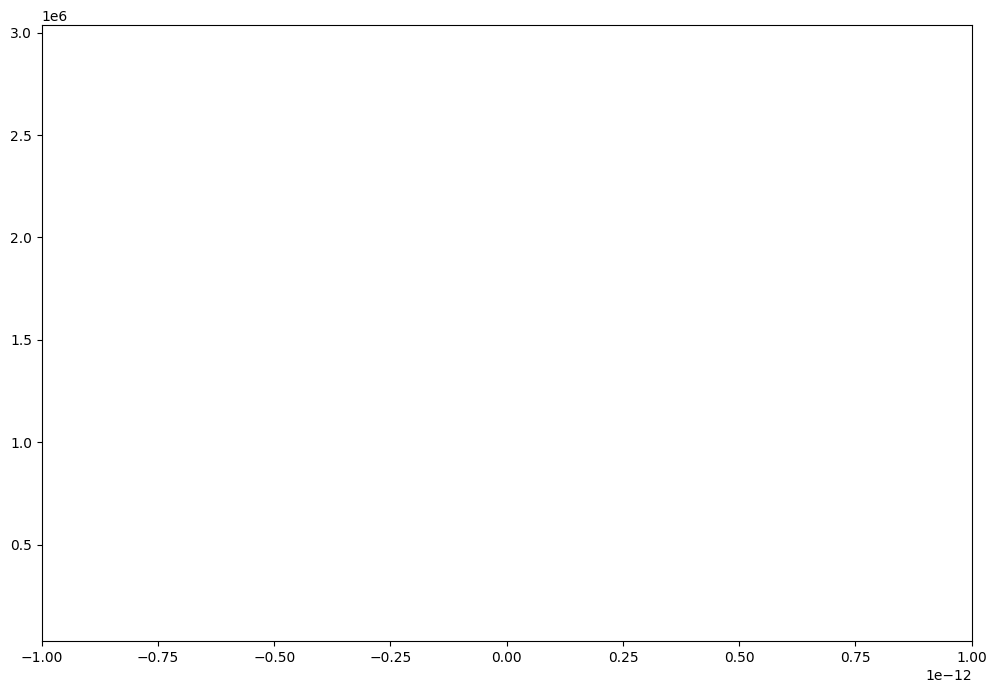

In [51]:
plt.figure(figsize=(12,8))
plt.scatter(np.expm1(scaler_X.inverse_transform(X_test))[:,5], np.expm1(scaler_y.inverse_transform(y_test)))
plt.scatter(np.expm1(scaler_X.inverse_transform(X_test))[:,5], np.expm1(scaler_y.inverse_transform(y_pred.reshape(-1,1))))

In [52]:
r2_score(np.expm1(scaler_y.inverse_transform(y_test)), np.expm1(scaler_y.inverse_transform(y_pred.reshape(-1,1))))

0.7322769713350905

In [53]:
X_log

,avg_price_5,bathrooms_total,bedrooms_extra,bedrooms,stories_total,size_interior,lng,lat,parkings,household_income,...,loc_cafes,loc_quiet,loc_parks,building_type_Apartment,building_type_House,building_type_Row / Townhouse,building_type_Semi-Detached,ownership_type_group_ids_0,ownership_type_group_ids_1,ownership_type_group_ids_2
0,634900.0,2.0,0.0,2.0,1.0,1072.000000,-83.029633,42.265783,0.0,125972.08190,...,1.5,4.5,3.5,1.0,0.0,0.0,0.0,0.0,0.000000,0.693147
1,1128779.8,3.0,0.0,4.0,2.0,1965.881818,-83.087577,42.228649,0.0,205459.75390,...,1.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.693147,0.000000
2,319180.0,1.0,0.0,4.0,1.0,1040.426146,-83.056441,42.304613,0.0,76724.51700,...,2.5,3.0,3.5,0.0,1.0,0.0,0.0,0.0,0.693147,0.000000
3,299537.6,1.0,0.0,3.0,1.0,3718.455676,-83.055635,42.302468,0.0,78194.19500,...,2.0,4.0,3.5,0.0,1.0,0.0,0.0,0.0,0.693147,0.000000
4,895919.8,3.0,0.0,4.0,2.0,2700.000000,-83.093660,42.134249,0.0,143383.80870,...,0.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.693147,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126390,433900.0,2.0,0.0,3.0,1.0,1143.903197,-77.495523,46.099807,3.0,97619.41780,...,0.0,4.5,0.0,0.0,1.0,0.0,0.0,0.0,0.693147,0.000000
126391,378900.0,1.0,0.0,3.0,1.0,1039.771184,-77.480159,46.100407,3.0,116972.00490,...,0.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.693147,0.000000
126983,233760.0,2.0,0.0,2.0,1.0,1050.000000,-89.246254,48.382907,0.0,78865.21810,...,3.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.693147
126984,311920.0,1.0,0.0,2.0,1.0,1019.000000,-89.306371,48.389386,0.0,128217.20300,...,1.5,4.5,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.693147


In [54]:
y

0          399900.0
1          959900.0
2          299900.0
3          399000.0
4          999900.0
            ...    
126390     399900.0
126391     429900.0
126983     165000.0
126984     375000.0
129909    1500000.0
Name: price, Length: 62579, dtype: float64

In [55]:
df_log = X_log.copy(deep=True)
df_log["price_log"] = np.log1p(y)

In [56]:
df_log.corr(numeric_only=True)["price_log"].sort_values(ascending=False).head(20)

price_log                     1.000000
avg_price_5                   0.721947
bathrooms_total               0.620237
size_interior                 0.568217
household_income              0.469807
individual_income             0.469807
bedrooms                      0.465600
parkings                      0.422665
single_family                 0.360155
building_type_House           0.339924
ownership_type_group_ids_1    0.329547
edu_bachelor_degree           0.293897
stories_total                 0.288323
owners                        0.286369
edu_university_certificate    0.266641
bedrooms_extra                0.257808
edu_post_graduate_degree      0.235601
multi_family                  0.232584
age_15_to_19                  0.223779
age_10_to_14                  0.194554
Name: price_log, dtype: float64

In [57]:
X.columns

Index(['avg_price_5', 'bathrooms_total', 'bedrooms_extra', 'bedrooms',
       'stories_total', 'size_interior', 'lng', 'lat', 'parkings',
       'household_income', 'individual_income', 'commute_transit',
       'commute_foot', 'commute_bicycle', 'commute_drive', 'single_family',
       'multi_family', 'single_person', 'multi_person', 'total_individuals',
       'age_0_to_4', 'age_5_to_9', 'age_10_to_14', 'age_15_to_19',
       'age_20_to_34', 'age_35_to_49', 'age_50_to_64', 'age_65_to_79',
       'age_80_plus', 'owners', 'renters', 'lang_en_only', 'lang_fr_only',
       'lang_en_and_fr', 'lang_other', 'edu_no_high_school', 'edu_high_school',
       'edu_trade_certificate', 'edu_college_certificate',
       'edu_university_certificate', 'edu_bachelor_degree',
       'edu_post_graduate_degree', 'household_children',
       'area_single_detached', 'area_semi_detached', 'area_duplex',
       'area_row_houses', 'area_apt_1_to_4_floors', 'area_apt_5_plus_floors',
       'loc_high_schools', 